<h1> Brain Tumor Detection using Pre-Trained MobileNet model </h1>

<p> In this notebook, detection of Brain tumors has been done by using Computer Vision. A pre-trained MobileNet model with ImageNet weights has been used to perform this task. Keras API and tensorflow have been used in this notebook </p>

 <h2> Importing necessary Libraries </h2> 

In [11]:
from IPython.display import clear_output
!pip install imutils pandas seaborn matplotlib opencv-python scikit-image scikit-learn tensorflow lightgbm xgboost numpy
clear_output()

In [14]:
!pip install tensorflow


[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [18]:
import os

# Create folders
folders = [
    'TRAIN/YES', 'TRAIN/NO',
    'TEST/YES', 'TEST/NO',
    'VAL/YES', 'VAL/NO'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folders created successfully.")


Folders created successfully.


In [19]:
import os
import shutil
import random

IMG_PATH = './Brain_Tumor_Detection/'
output_dirs = ['TRAIN', 'VAL', 'TEST']

# Create directories if not present
for split in output_dirs:
    for label in ['YES', 'NO']:
        os.makedirs(f'{split}/{label}', exist_ok=True)

# Set your desired split ratios
test_ratio = 0.2
val_ratio = 0.2

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        full_class_path = os.path.join(IMG_PATH, CLASS)
        all_images = [f for f in os.listdir(full_class_path) if not f.startswith('.')]
        random.shuffle(all_images)

        total = len(all_images)
        test_size = int(total * test_ratio)
        val_size = int(total * val_ratio)

        test_imgs = all_images[:test_size]
        val_imgs = all_images[test_size:test_size + val_size]
        train_imgs = all_images[test_size + val_size:]

        for fname in test_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'TEST/{CLASS.upper()}/{fname}')

        for fname in val_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'VAL/{CLASS.upper()}/{fname}')

        for fname in train_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'TRAIN/{CLASS.upper()}/{fname}')


In [23]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [24]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [25]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

600 images loaded from VAL/ directory.


<h2> Plotting the number of samples in Training, Validation and Test sets </h2>

In [26]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

<h2> Let's Visualize the images we are working with </h2>

In [27]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

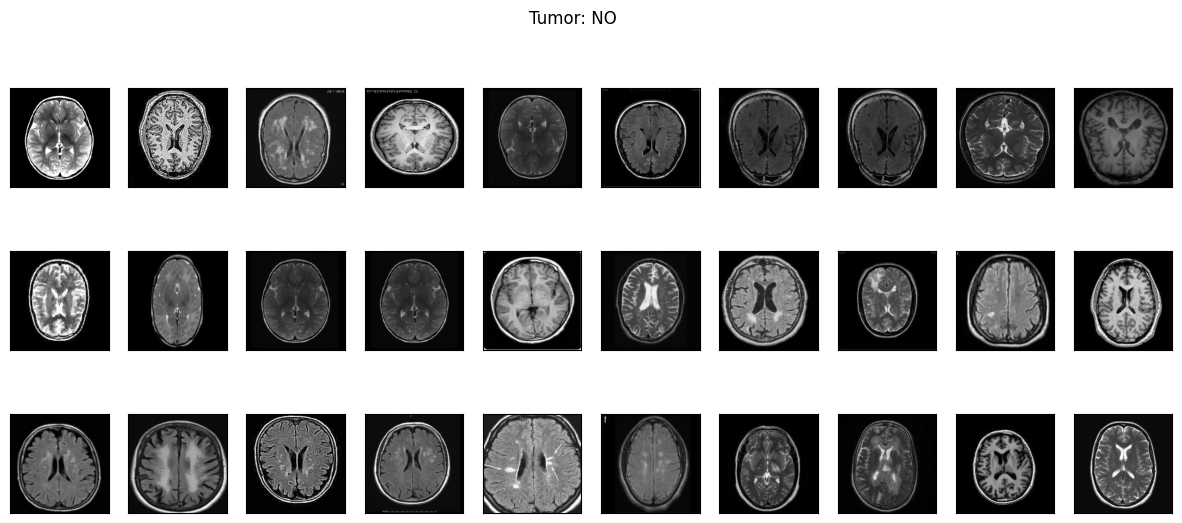

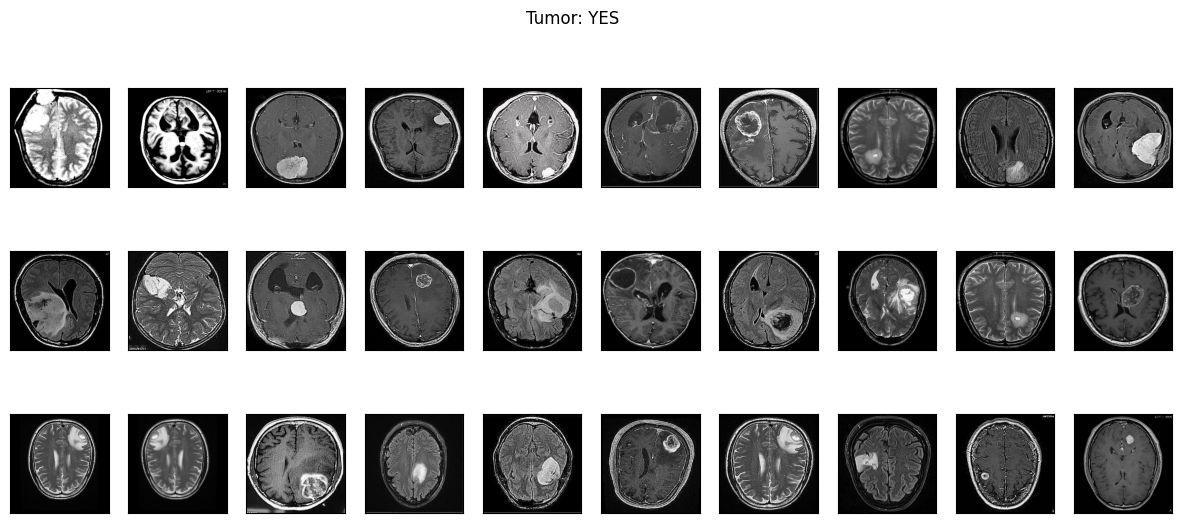

In [28]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images </h2>

<p> The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions. </p>

<p> This cropping is done by finding contours in the images using the OpenCV Library </p>

In [34]:

def crop_imgs(set_name, add_pixels_value=0, final_size=(224,224)):
    set_new = []
    
    for img in tqdm(set_name):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) == 0:
            # if no contours found, skip this image
            continue

        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        cropped_resized = cv2.resize(cropped, final_size, interpolation=cv2.INTER_AREA)
        set_new.append(cropped_resized)

    return np.array(set_new)


In [35]:
import imutils
img = cv2.imread('./VAL/NO/no101.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visualize how the cropping works </h2>

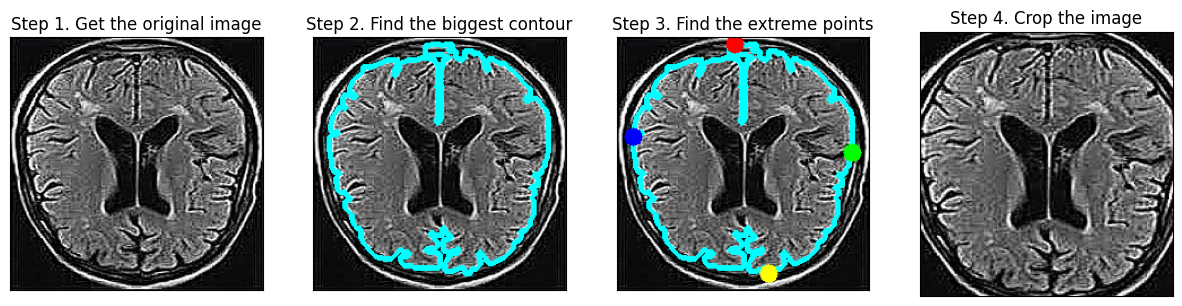

In [36]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [37]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

100%|██████████| 600/600 [00:00<00:00, 2010.80it/s]


<h2> Let's visualize the images after being cropped </h2>

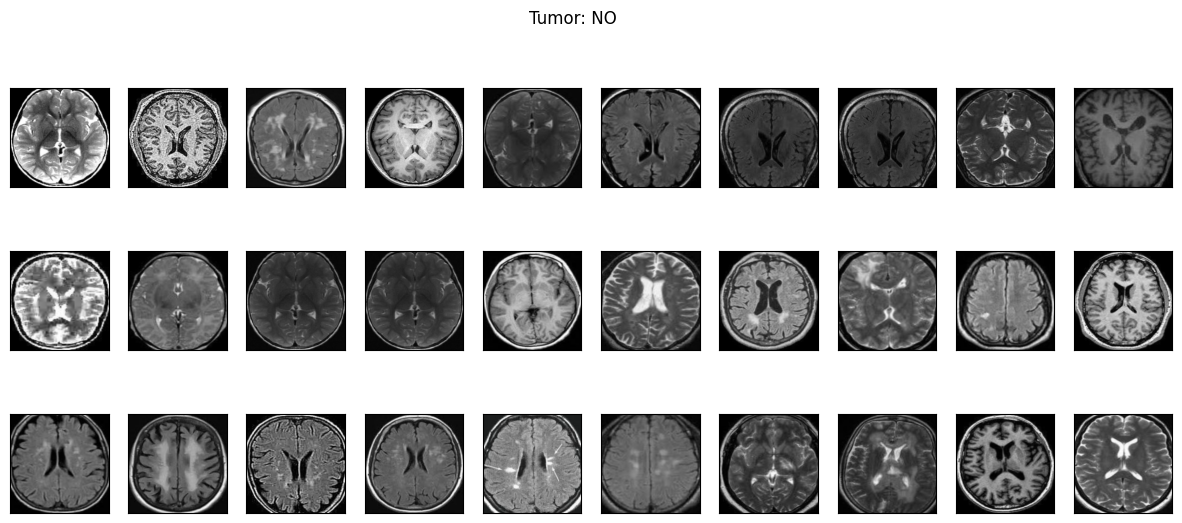

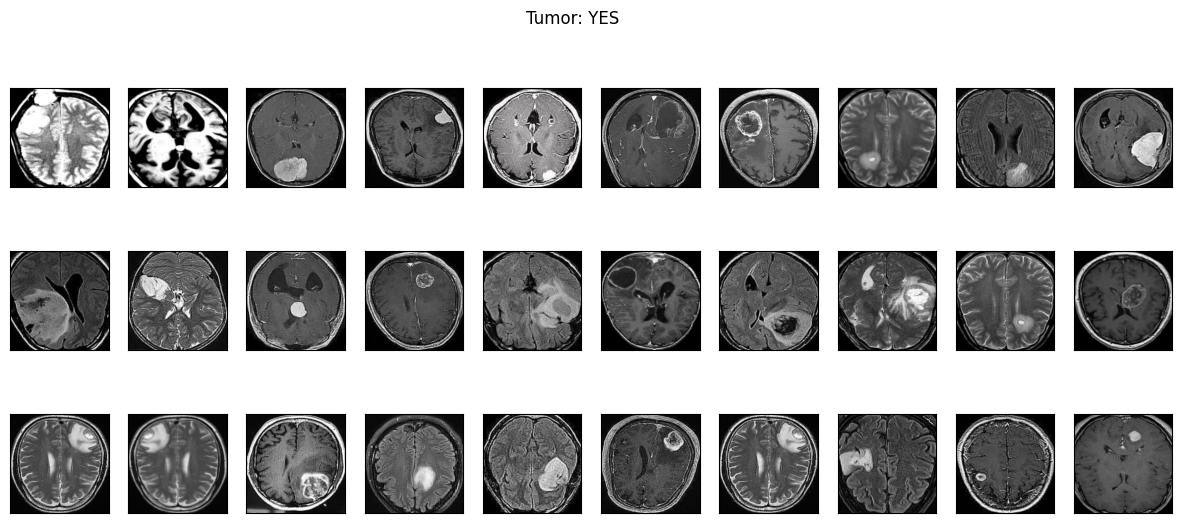

In [38]:
plot_samples(X_train_crop, y_train, labels, 30)

In [39]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [41]:
# saving new images to the folder
import os

# List of folders you want to create
folders = [
    'TRAIN_CROP/YES', 'TRAIN_CROP/NO',
    'TEST_CROP/YES', 'TEST_CROP/NO',
    'VAL_CROP/YES', 'VAL_CROP/NO'
]

# Create each folder if it doesn't exist
for folder in folders:
    os.makedirs(folder, exist_ok=True)


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [42]:

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

<h2> Resizing the images </h2>

<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts </p>

In [43]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [44]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.68..149.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..115.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..120.061].
Clipping input data 

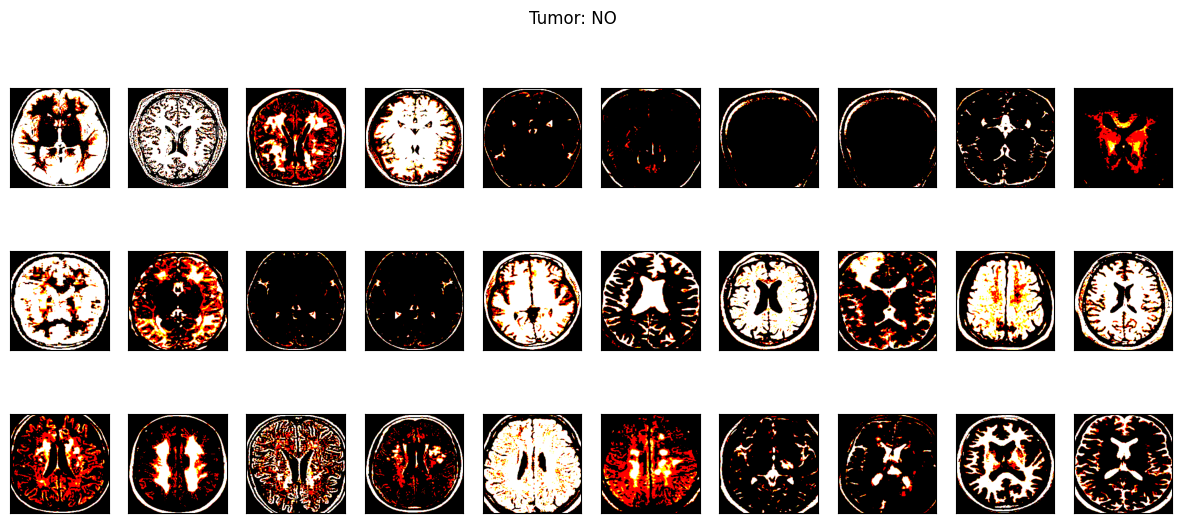

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

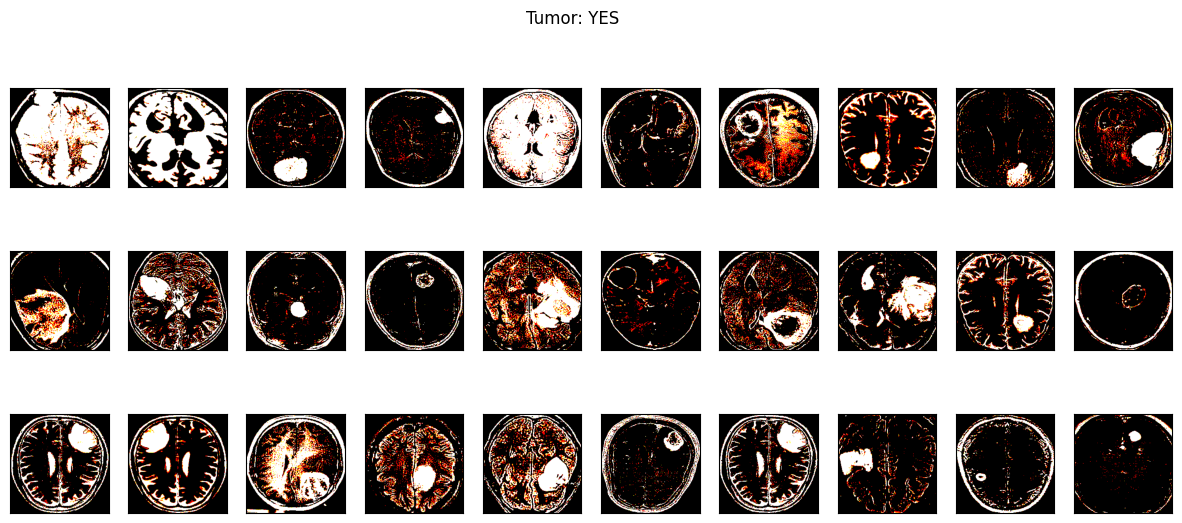

In [45]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have </p>

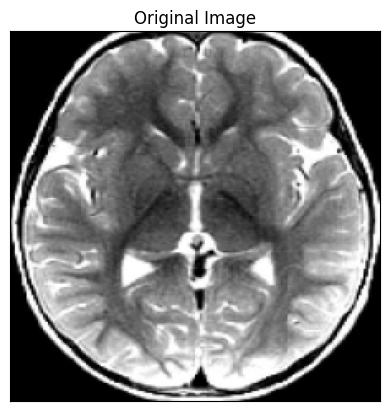

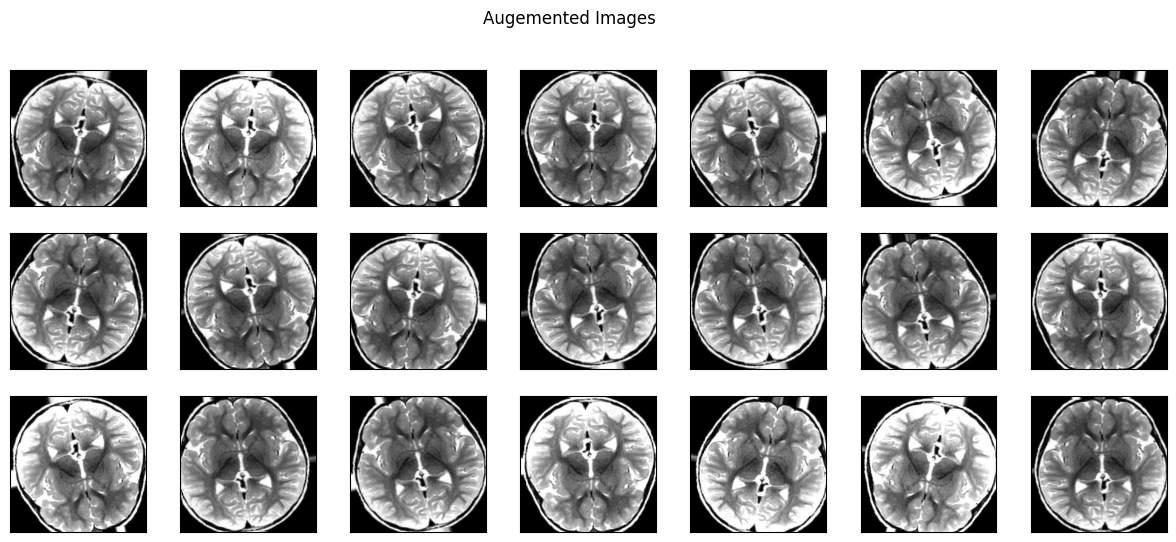

In [48]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [50]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


<h2> Creating the model </h2>

<p> Here we will be using a pretrained MobileNet model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [51]:
base_Neural_Net= MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50176)          │       200,704 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,276,161 (62.09 MB)

 Trainable params: 12,946,433 (49.39 MB)

 Non-trainable params: 3,329,728 (12.70 MB)

> <h2> TRAINING !!! </h2>

In [53]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

c:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 880ms/step - AUC: 0.8045 - accuracy: 0.7418 - loss: 0.6938 - val_AUC: 0.8660 - val_accuracy: 0.6475 - val_loss: 1.7393
Epoch 2/30
 7/50 ━━━━━━━━━━━━━━━━━━━━ 17s 405ms/step - AUC: 0.9179 - accuracy: 0.8269 - loss: 0.3716

c:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - AUC: 0.9320 - accuracy: 0.8414 - loss: 0.3382 - val_AUC: 0.9202 - val_accuracy: 0.6875 - val_loss: 1.2641
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 515ms/step - AUC: 0.9323 - accuracy: 0.8542 - loss: 0.3297 - val_AUC: 0.9742 - val_accuracy: 0.8600 - val_loss: 0.4229
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - AUC: 0.9517 - accuracy: 0.8664 - loss: 0.2781 - val_AUC: 0.9589 - val_accuracy: 0.8875 - val_loss: 0.3950
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - AUC: 0.9494 - accuracy: 0.8831 - loss: 0.2850 - val_AUC: 0.9725 - val_accuracy: 0.9450 - val_loss: 0.1972
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - AUC: 0.9492 - accuracy: 0.8889 - loss: 0.2877 - val_AUC: 0.9658 - val_accuracy: 0.9300 - val_loss: 0.2407
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 497ms/step - AUC: 0.9607 - accuracy: 0.8959 - loss: 0.2567 - val_AUC: 0.9860 - val_accuracy: 0.9350 - val_loss: 0.1556
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/s

<h2>Let's have a look at the performance of our model </h2>

<h3> Validating with the training set </h3>

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step
Train Accuracy = 0.97


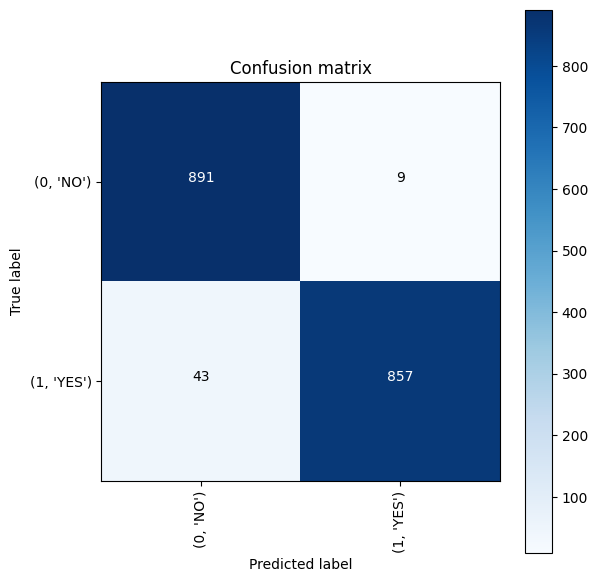

In [54]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

<h3> Validating with the Validation set</h3>

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step
Val Accuracy = 0.97


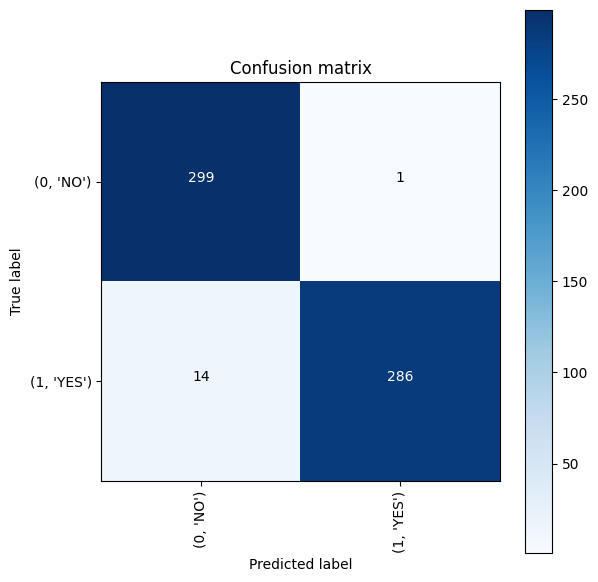

In [55]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

<h3> Validating with the Test set</h3>

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step
Test Accuracy = 0.95


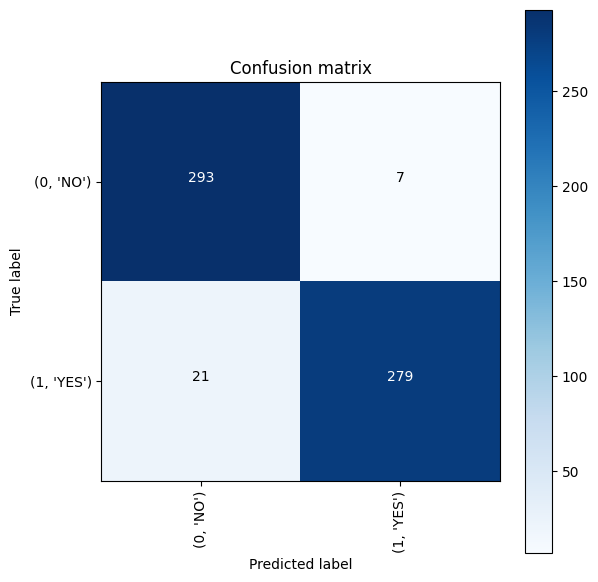

In [56]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [58]:
prob_pred = model.predict(X_test_prep)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step


<h2> Let's see the other performance metrics on the test set </h2>

In [59]:
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, predictions))
print('Precision score is :', metrics.precision_score(y_test, predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9533333333333334
Precision score is : 0.9543227473163779
Recall score is : 0.9533333333333334
F1 Score is : 0.9533079120854688
ROC AUC Score is : 0.9944333333333333
Cohen Kappa Score: 0.9066666666666666
		Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       300
           1       0.98      0.93      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

